In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr, norm, ttest_rel, f

# Load data
study_name="hiring algorithms"
specification_name="default persona"
human_file = f"{study_name} human data values anonymized.csv"
twin_file  = f"{study_name} twins data values anonymized.csv"
df_human = pd.read_csv(human_file, header=0, skiprows=[1,2])
df_twin  = pd.read_csv(twin_file,  header=0, skiprows=[1,2])


# ─── NEW 08/04/25: Recode Q9 and Q14 ─────────────────────────────────────────────────────

# Mapping for Q9: 3→1, 4→2, 2→3, 1→4
recode_Q9 = {3: 1,
             4: 2,
             2: 3,
             1: 4}

# Mapping for Q14: 1→1, 3→2, 4→3, 2→4
recode_Q14 = {1: 1,
              3: 2,
              4: 3,
              2: 4}

for df in (df_human, df_twin):
    # ensure numeric before mapping (optional)
    df['Q9']  = pd.to_numeric(df['Q9'], errors='coerce').map(recode_Q9)
    df['Q14'] = pd.to_numeric(df['Q14'], errors='coerce').map(recode_Q14)
# ────────────────────────────────────────────────────────



for df in (df_human, df_twin):
    # build the masks *on this* df
    conds = [
        df['FL_7_DO_AlgorithmicHiring'] == 1,
        df['FL_7_DO_HiringTeam']      == 1,       
    ]
    # choices for each cond_job*
    # for cond_job1 & 3: algo if algohire, else team
    df['cond_job1'] = np.select(conds, ['algo', 'team'], default=np.nan)
    df['cond_job3'] = np.select(conds, ['algo', 'team'], default=np.nan)
    # for cond_job2 & 4: team if algohire, else algo
    df['cond_job2'] = np.select(conds, ['team', 'algo'], default=np.nan)
    df['cond_job4'] = np.select(conds, ['team', 'algo'], default=np.nan)

#ratings for each phase 2 job: 
# mapping for each job under each flag
ht_map = {1: 'Q22', 2: 'Q24', 3: 'Q25', 4: 'Q26'}
algo_map = {1: 'Q27', 2: 'Q28', 3: 'Q29', 4: 'Q30'}

for df in (df_human, df_twin):
    # initialize all new columns to NaN
    for i in range(1, 5):
        for k in range(1, 9):
            df[f'job{i}_item{k}'] = np.nan

    # fill in for HiringTeam
    mask_ht = df['FL_7_DO_HiringTeam'] == 1
    for i, base in ht_map.items():
        for k in range(1, 9):
            df.loc[mask_ht, f'job{i}_item{k}'] = df.loc[mask_ht, f'{base}_{k}']

    # fill in for AlgorithmicHiring
    mask_algo = df['FL_7_DO_AlgorithmicHiring'] == 1
    for i, base in algo_map.items():
        for k in range(1, 9):
            df.loc[mask_algo, f'job{i}_item{k}'] = df.loc[mask_algo, f'{base}_{k}']

out_file  = f"{study_name} {specification_name} human data processed.csv"
df_human.to_csv(out_file, index=False) 
out_file  = f"{study_name} {specification_name} twins data processed.csv"
df_twin.to_csv(out_file, index=False)  

# Compute results
results = []

#####################################################
#start with DV that doesn't have a condition:
#define relevant columns:
#condition variable names:
condition_vars = ['']
# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond       = condition_vars[0]
    cond_h     = f"{cond}_human"
    cond_t     = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False
    
#different condition assignments for each DV (unique to this study)    
dv_to_cond = {}

#raw responses:
raw_vars = []

#DVs:
DV_vars=['Q6','Q8','Q9','Q10','Q13','Q14','Q15','Q16']
DV_vars_min=[1]*8
DV_vars_max=[5,5,4,5,5,4,5,5]
#DVs: domain=social?
DV_vars_social=[1]*8
DV_vars_social_map  = dict(zip(DV_vars,  DV_vars_social ))
#DVs: domain=cognitive?
DV_vars_cognitive=[0]*8
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
#DVs: replicating know human bias?
DV_vars_known=[0]*8
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
#DVs: preference measure?
DV_vars_pref=[1]*8
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
#DVs: stimuli dependent?
DV_vars_stim=[0]*8
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
#DVs: knowledge question?
DV_vars_know=[0]*8
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
#DVs: political question?
DV_vars_politics=[0]*8
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))

#merging key
merge_key = ['TWIN_ID']

# Merge on TWIN_ID
df = pd.merge(
    df_human,
    df_twin,
    on=merge_key,
    suffixes=('_human', '_twin')
)

print("Merged df columns:", df.columns.tolist())

#Fix dtypes
for var in raw_vars + DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors='coerce')
    df[f"{var}_twin" ] = pd.to_numeric(df[f"{var}_twin" ], errors='coerce')

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars,      DV_vars_min)}
#min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
#min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars,      DV_vars_max)}
#max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
#max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})   

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var]
    

for var in DV_vars:
    #07/18/26: condition assignment different for each DV. 
    col_h = f"{var}_human"
    col_t = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"
    if cond_exists:
        cols = [col_h, col_t, cond_h, cond_t,min_col,max_col]
    else:
        cols = [col_h, col_t,min_col,max_col]
    pair = (
    df[cols]
      .dropna(subset=[col_h, col_t])
    )
# # look up the right condition for this DV
#     cond    = dv_to_cond[var]           # e.g. 'condition_green'
#     col_h   = f"{var}_human"
#     col_t   = f"{var}_twin"
#     min_col = f"{var}_min"
#     max_col = f"{var}_max"

#     if cond:
#         # only if there's a real condition
#         cond_h = f"{cond}_human"
#         cond_t = f"{cond}_twin"
#         cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
#         pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
#     else:
#         # no condition variable for this DV
#         cols = [col_h, col_t, min_col, max_col]
#         pair = df[cols].dropna(subset=[col_h, col_t])
   


    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n    = len(pair)
    if n >= 4:
        r, _    = pearsonr(pair[col_h], pair[col_t])
        z_f     = np.arctanh(r)
        se      = 1 / np.sqrt(n - 3)
        z_crit  = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit*se, z_f + z_crit*se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score    = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff      = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy      = 1 - mean_abs_diff / (max_val - min_val)
            
        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()
            
        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])
        
        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)
        
        # F‐test for equal variances 
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t>0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2),
                          1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan
            
        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair)>3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h]==levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h]==levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan
                
        #    For twins:
        if cond_exists and len(pair)>3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t]==levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t]==levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan        
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = f_stat = p_f = np.nan
        d_human = d_twin = np.nan

    results.append({
        'study name': study_name,
        'persona specification': specification_name,
        'variable name': var,
#        'variable type (raw response/DV)':     'DV',
        'correlation between the responses from humans vs. their twins':        r,
        'CI_lower': lo_r,
        'CI_upper': hi_r,
        'z-score for correlation between humans vs. their twins':  z_score,
        'accuracy between humans vs. their twins': accuracy,
        'mean_human': mean_h,
        'mean_twin': mean_t,
        'paired t-test t-stat': t_stat,
        'paired t-test p-value': p_val,
        'std_human': std_h,
        'std_twin': std_t,
        'variance test F-stat': f_stat,
        'variance test p-value': p_f,
        'effect size based on human': d_human,
        'effect size based on twin': d_twin,
        'domain=social?':DV_vars_social_map.get(var, np.nan),
        'domain=cognitive?':DV_vars_cognitive_map.get(var, np.nan),
        'replicating know human bias?':DV_vars_known_map.get(var, np.nan),
        'preference measure?':DV_vars_pref_map.get(var, np.nan),
        'stimuli dependent?':DV_vars_stim_map.get(var, np.nan),
        'knowledge question?':DV_vars_know_map.get(var, np.nan),
        'political question?':DV_vars_politics_map.get(var, np.nan),
        'sample size':        n
    })
###################################################
    
    
#############################now do the DVs that have conditions: 
#define relevant columns:
#condition variable names:
condition_vars = ['cond_job1','cond_job2','cond_job3','cond_job4']

# Check if we have a real condition var
if condition_vars and condition_vars[0].strip():
    cond       = condition_vars[0]
    cond_h     = f"{cond}_human"
    cond_t     = f"{cond}_twin"
    cond_exists = True
else:
    cond_exists = False
    
#different condition assignments for each DV (unique to this study)    
dv_to_cond = {
    f'job{i}_item{k}': f'cond_job{i}'
    for i in range(1, 5)
    for k in range(1, 9)
}

#raw responses:
raw_vars = []

#DVs:
#DV_vars=['task 1 - attitude_change','task 2 - S1','task 2 - S2','task 2 - S3','task 3 - S1','task 3 - S2','task 3 - S3']
DV_vars = [f'job{i}_item{k}' 
           for i in range(1, 5) 
           for k in range(1, 9)]

DV_vars_min=[1]*32
DV_vars_max=[7]*32
#DVs: domain=social?
DV_vars_social=[1]*32
DV_vars_social_map  = dict(zip(DV_vars,  DV_vars_social ))
#DVs: domain=cognitive?
DV_vars_cognitive=[0]*32
DV_vars_cognitive_map = dict(zip(DV_vars, DV_vars_cognitive))
#DVs: replicating know human bias?
DV_vars_known=[0]*32
DV_vars_known_map = dict(zip(DV_vars, DV_vars_known))
#DVs: preference measure?
DV_vars_pref=[1]*32
DV_vars_pref_map = dict(zip(DV_vars, DV_vars_pref))
#DVs: stimuli dependent?
DV_vars_stim=[1]*32
DV_vars_stim_map = dict(zip(DV_vars, DV_vars_stim))
#DVs: knowledge question?
DV_vars_know=[0]*32
DV_vars_know_map = dict(zip(DV_vars, DV_vars_know))
#DVs: political question?
DV_vars_politics=[0]*32
DV_vars_politics_map = dict(zip(DV_vars, DV_vars_politics))

#merging key
merge_key = ['TWIN_ID']

# Merge on TWIN_ID
df = pd.merge(
    df_human,
    df_twin,
    on=merge_key,
    suffixes=('_human', '_twin')
)

print("Merged df columns:", df.columns.tolist())

#Fix dtypes
for var in raw_vars + DV_vars:
    df[f"{var}_human"] = pd.to_numeric(df[f"{var}_human"], errors='coerce')
    df[f"{var}_twin" ] = pd.to_numeric(df[f"{var}_twin" ], errors='coerce')

# build min/max maps from both raw_vars and DV_vars
min_map = {v: mn for v, mn in zip(DV_vars,      DV_vars_min)}
#min_map = {v: mn for v, mn in zip(raw_vars,      raw_vars_min)}
#min_map.update({v: mn for v, mn in zip(DV_vars,   DV_vars_min)})

max_map = {v: mx for v, mx in zip(DV_vars,      DV_vars_max)}
#max_map = {v: mx for v, mx in zip(raw_vars,      raw_vars_max)}
#max_map.update({v: mx for v, mx in zip(DV_vars,   DV_vars_max)})   

# now add _min and _max columns for every variable in the union
for var in min_map:
    df[f"{var}_min"] = min_map[var]
    df[f"{var}_max"] = max_map[var] 

for var in DV_vars:
    #07/18/26: condition assignment different for each DV. 
#     col_h = f"{var}_human"
#     col_t = f"{var}_twin"
#     min_col = f"{var}_min"
#     max_col = f"{var}_max"
#     if cond_exists:
#         cols = [col_h, col_t, cond_h, cond_t,min_col,max_col]
#     else:
#         cols = [col_h, col_t,min_col,max_col]
#     pair = (
#     df[cols]
#       .dropna(subset=[col_h, col_t])
#     )
# look up the right condition for this DV
    cond    = dv_to_cond[var]           # e.g. 'condition_green'
    col_h   = f"{var}_human"
    col_t   = f"{var}_twin"
    min_col = f"{var}_min"
    max_col = f"{var}_max"

    if cond:
        # only if there's a real condition
        cond_h = f"{cond}_human"
        cond_t = f"{cond}_twin"
        cols = [col_h, col_t, cond_h, cond_t, min_col, max_col]
        pair = df[cols].dropna(subset=[col_h, col_t, cond_h, cond_t])
    else:
        # no condition variable for this DV
        cols = [col_h, col_t, min_col, max_col]
        pair = df[cols].dropna(subset=[col_h, col_t])
    
   
    min_val = pair[min_col].iloc[0]
    max_val = pair[max_col].iloc[0]
    n    = len(pair)
    if n >= 4:
        r, _    = pearsonr(pair[col_h], pair[col_t])
        z_f     = np.arctanh(r)
        se      = 1 / np.sqrt(n - 3)
        z_crit  = norm.ppf(0.975)
        lo_z, hi_z = z_f - z_crit*se, z_f + z_crit*se
        lo_r, hi_r = np.tanh(lo_z), np.tanh(hi_z)
        z_score    = z_f / se
        # Accuracy = mean absolute diff / range
        if pd.isna(min_val) or pd.isna(max_val) or max_val == min_val:
            accuracy = np.nan
        else:
            # compute mean absolute difference
            abs_diff      = np.abs(pair[col_h] - pair[col_t])
            mean_abs_diff = abs_diff.mean()
            accuracy      = 1 - mean_abs_diff / (max_val - min_val)
            
        mean_h = pair[col_h].mean()
        mean_t = pair[col_t].mean()
            
        # Paired t‐test
        t_stat, p_val = ttest_rel(pair[col_h], pair[col_t])
        
        std_h = pair[col_h].std(ddof=1)
        std_t = pair[col_t].std(ddof=1)
        
        # F‐test for equal variances 
        df1 = df2 = n - 1
        f_stat = (std_h**2 / std_t**2) if std_t>0 else np.nan
        # two‐tailed p‐value:
        if not np.isnan(f_stat):
            p_f = 2 * min(f.cdf(f_stat, df1, df2),
                          1 - f.cdf(f_stat, df1, df2))
        else:
            p_f = np.nan
            
        # Effect sizes (Cohen's d) across conditions
        #    For humans:
        if cond_exists and len(pair)>3:
            levels_h = pair[cond_h].unique()
            if len(levels_h) == 2:
                g1 = pair.loc[pair[cond_h]==levels_h[0], col_h]
                g2 = pair.loc[pair[cond_h]==levels_h[1], col_h]
                n1, n2 = len(g1), len(g2)
                # pooled sd
                s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
                d_human = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
            else:
                d_human = np.nan
        else:
            d_human = np.nan
                
        #    For twins:
        if cond_exists and len(pair)>3:
            levels_t = pair[cond_t].unique()
            if cond_exists and len(levels_t) == 2:
                g1 = pair.loc[pair[cond_t]==levels_t[0], col_t]
                g2 = pair.loc[pair[cond_t]==levels_t[1], col_t]
                n1, n2 = len(g1), len(g2)
                s_pool = np.sqrt(((n1-1)*g1.var(ddof=1)+(n2-1)*g2.var(ddof=1)) / (n1+n2-2))
                d_twin = (g1.mean() - g2.mean()) / s_pool if s_pool>0 else np.nan
            else:
                d_twin = np.nan
        else:
            d_twin = np.nan        
    else:
        r = lo_r = hi_r = z_score = accuracy = mean_h = mean_t = t_stat = p_val = std_h = std_t = f_stat = p_f = np.nan
        d_human = d_twin = np.nan

    results.append({
        'study name': study_name,
        'persona specification': specification_name,
        'variable name': var,
#        'variable type (raw response/DV)':     'DV',
        'correlation between the responses from humans vs. their twins':        r,
        'CI_lower': lo_r,
        'CI_upper': hi_r,
        'z-score for correlation between humans vs. their twins':  z_score,
        'accuracy between humans vs. their twins': accuracy,
        'mean_human': mean_h,
        'mean_twin': mean_t,
        'paired t-test t-stat': t_stat,
        'paired t-test p-value': p_val,
        'std_human': std_h,
        'std_twin': std_t,
        'variance test F-stat': f_stat,
        'variance test p-value': p_f,
        'effect size based on human': d_human,
        'effect size based on twin': d_twin,
        'domain=social?':DV_vars_social_map.get(var, np.nan),
        'domain=cognitive?':DV_vars_cognitive_map.get(var, np.nan),
        'replicating know human bias?':DV_vars_known_map.get(var, np.nan),
        'preference measure?':DV_vars_pref_map.get(var, np.nan),
        'stimuli dependent?':DV_vars_stim_map.get(var, np.nan),
        'knowledge question?':DV_vars_know_map.get(var, np.nan),
        'political question?':DV_vars_politics_map.get(var, np.nan),
        'sample size':        n
    })
################################################
    
       
    
    
#print results:
    
# results DataFrame
corr_df = pd.DataFrame(results)
print(corr_df)

# save output as csv - unit of observation is comparison between humans and twins:
out_file  = f"{study_name} {specification_name} meta analysis.csv"
corr_df.to_csv(out_file, index=False)  

##### participant‐level data (only rows where the DV value is NOT NaN) #####

# combine all DVs
base_DVs = ['Q6','Q8','Q9','Q10','Q13','Q14','Q15','Q16']
# the 32 job items
job_DVs = [f'job{i}_item{k}' 
           for i in range(1, 5) 
           for k in range(1, 9)]
# concatenate them
DV_vars = base_DVs + job_DVs

def make_long(df, respondent_type):
    # pick off TWIN_ID + the DVs, then melt
    long = (
        df[['TWIN_ID'] + DV_vars]
          .melt(
              id_vars='TWIN_ID',
              value_vars=DV_vars,
              var_name='variable_name',
              value_name='value'
          )
    )
    long['respondent_type']    = respondent_type
    long['study_name']         = study_name
    long['specification_name'] = specification_name
    return long

# build the two halves
long_h = make_long(df_human, 'human')
long_t = make_long(df_twin,  'twin')

# stack them and keep only non-NaN values
df_long = pd.concat([long_h, long_t], ignore_index=True)
df_long = df_long[df_long['value'].notna()]

print(df_long.head())

# save output as csv - unit of observation is TWIN_ID (only non-NaNs)
out_file = f"{study_name} {specification_name} meta analysis individual level.csv"
df_long.to_csv(out_file, index=False)

print("done")


C:\Users\ot2107\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Merged df columns: ['StartDate_human', 'EndDate_human', 'Progress_human', 'Duration (in seconds)_human', 'Finished_human', 'RecordedDate_human', 'Q31_human', 'Q6_human', 'Q8_human', 'Q9_human', 'Q10_human', 'Q13_human', 'Q14_human', 'Q15_human', 'Q16_human', 'Q1_human', 'Q2_human', 'Q3_human', 'Q4_human', 'Q5_human', 'Q17_human', 'Q18_human', 'Q19_human', 'Q20_human', 'Q27_1_human', 'Q27_2_human', 'Q27_3_human', 'Q27_4_human', 'Q27_5_human', 'Q27_6_human', 'Q27_7_human', 'Q27_8_human', 'Q28_1_human', 'Q28_2_human', 'Q28_3_human', 'Q28_4_human', 'Q28_5_human', 'Q28_6_human', 'Q28_7_human', 'Q28_8_human', 'Q29_1_human', 'Q29_2_human', 'Q29_3_human', 'Q29_4_human', 'Q29_5_human', 'Q29_6_human', 'Q29_7_human', 'Q29_8_human', 'Q30_1_human', 'Q30_2_human', 'Q30_3_human', 'Q30_4_human', 'Q30_5_human', 'Q30_6_human', 'Q30_7_human', 'Q30_8_human', 'Q22_1_human', 'Q22_2_human', 'Q22_3_human', 'Q22_4_human', 'Q22_5_human', 'Q22_6_human', 'Q22_7_human', 'Q22_8_human', 'Q24_1_human', 'Q24_2_human',

C:\Users\ot2107\AppData\Local\Temp\ipykernel_26364\1508477343.py:382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{var}_min"] = min_map[var]
C:\Users\ot2107\AppData\Local\Temp\ipykernel_26364\1508477343.py:383: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{var}_max"] = max_map[var]
C:\Users\ot2107\AppData\Local\Temp\ipykernel_26364\1508477343.py:382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all 

done


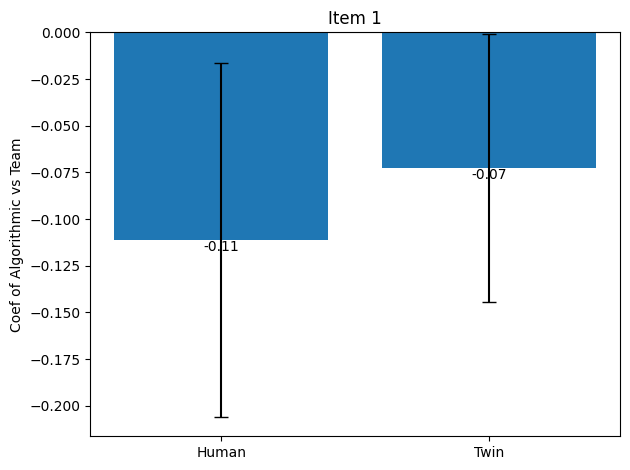

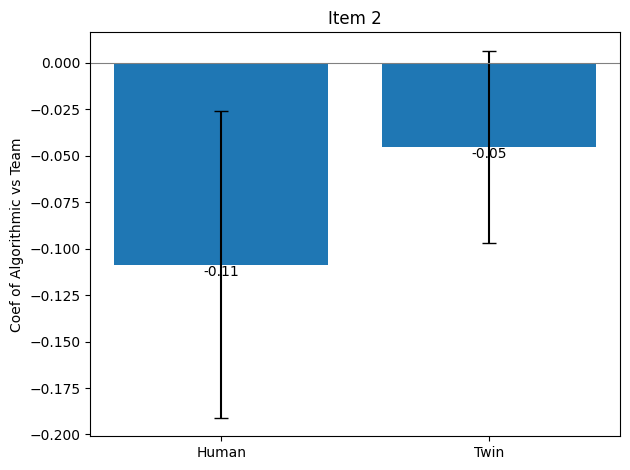

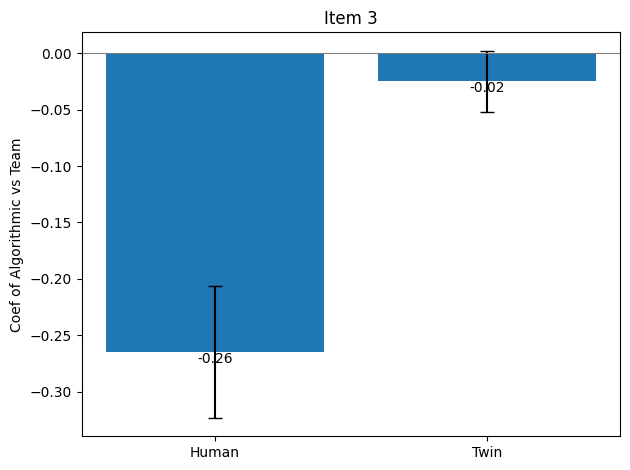

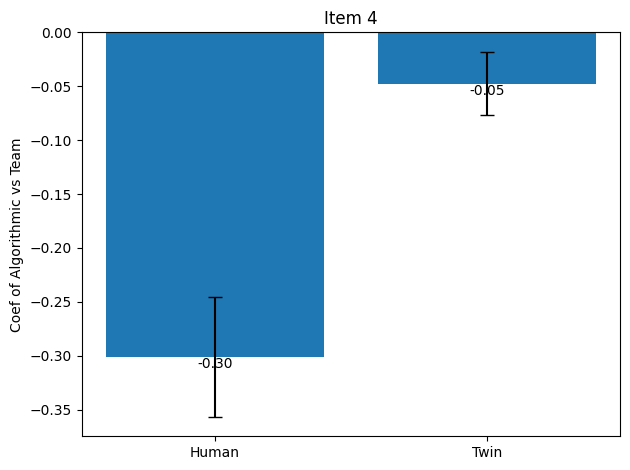

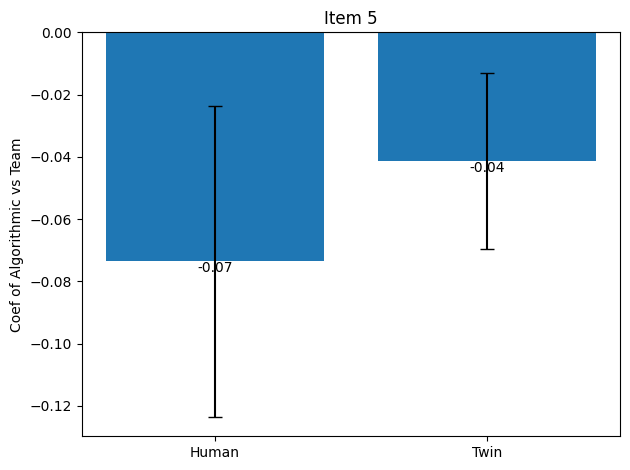

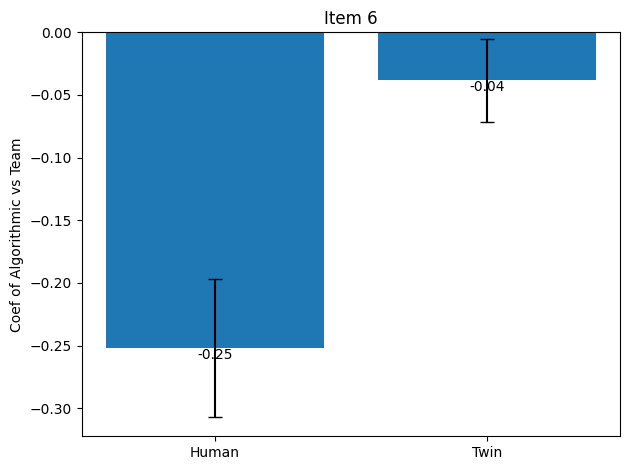

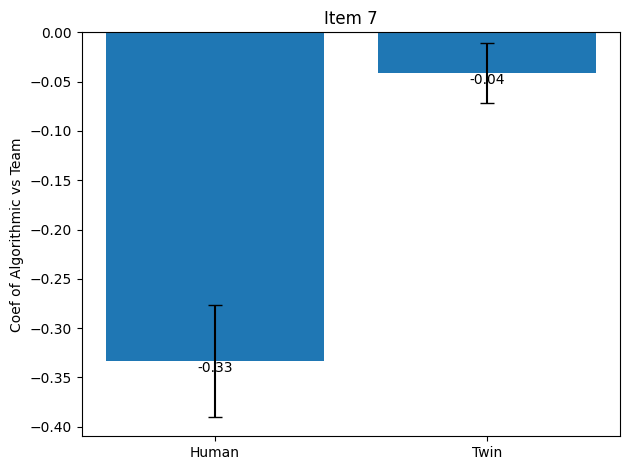

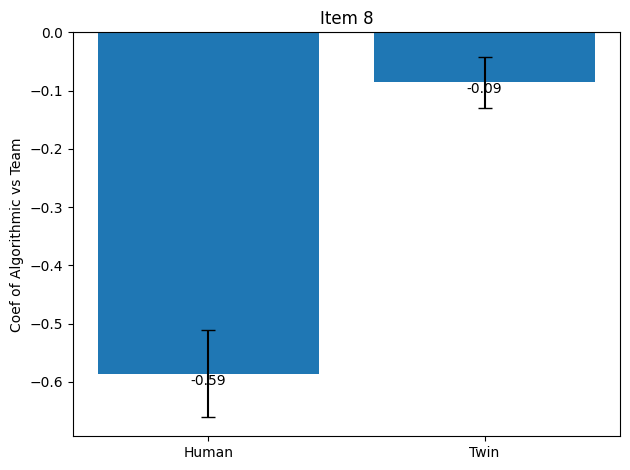

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# assume df_human, df_twin and job_DVs are already defined as before

def compute_coef_se(df, item_k):
    """Melt, filter to item_k, run FE‐OLS, return coef and se for cond_binary."""
    id_vars = ['TWIN_ID', 'cond_job1','cond_job2','cond_job3','cond_job4']
    df_long = (
        df.melt(id_vars=id_vars, value_vars=job_DVs,
                var_name='job_item', value_name='value')
          .dropna(subset=['value'])
    )
    suffix = f"_item{item_k}"
    df_k = df_long[df_long['job_item'].str.endswith(suffix)].copy()
    if df_k.empty:
        return np.nan, np.nan
    # extract job and its cond
    df_k['job'] = df_k['job_item'].str.extract(r'(job\d)_item\d+')
    df_k['cond'] = df_k.apply(lambda r: r[f'cond_{r.job}'], axis=1)
    df_k['cond_binary'] = (df_k['cond']=='algo').astype(int)
    # FE‐OLS
    mod = smf.ols('value ~ cond_binary + C(TWIN_ID) + C(job)', data=df_k).fit()
    return mod.params['cond_binary'], mod.bse['cond_binary']

def plot_items_human_vs_twin(df_human, df_twin):
    z95 = 1.96
    for k in range(1, 9):
        coef_h, se_h = compute_coef_se(df_human, k)
        coef_t, se_t = compute_coef_se(df_twin,  k)
        # if either is nan, skip
        if np.isnan(coef_h) and np.isnan(coef_t):
            continue

        # 95% CI error bars
        err_h = z95 * se_h
        err_t = z95 * se_t

        plt.figure()
        labels = ['Human', 'Twin']
        coefs  = [coef_h, coef_t]
        errs   = [err_h, err_t]
        bars = plt.bar(labels, coefs, yerr=errs, capsize=5)
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.ylabel('Coef of Algorithmic vs Team')
        plt.title(f'Item {k}')
        # optional: annotate bar values
        for bar, coef in zip(bars, coefs):
            plt.text(bar.get_x() + bar.get_width()/2, coef,
                     f"{coef:.2f}", ha='center',
                     va='bottom' if coef>=0 else 'top')
        plt.tight_layout()
        plt.show()

# Call once to draw all 8 plots
plot_items_human_vs_twin(df_human, df_twin)
